In [1]:
import torch, torchvision
import numpy as np
import math
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import matplotlib.pyplot as plt
import pandas as pd
import torchaudio
from torch import nn
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path
from tqdm.auto import tqdm
from torch import amp
from torch.amp import GradScaler
from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler, Dataset
from torch.optim.swa_utils import AveragedModel    
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.functional import pad
from tqdm.notebook import tqdm
import torchvision.utils as vutils
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [2]:
device

device(type='cuda')

In [3]:
config = {
    "dataset": {
        "train": {
            "table": "E:/data/train.csv",
            "data": "E:/data/bare_data/"
        },
        "val": {
            "table": "E:/data/val.csv",
            "data": "E:/data/bare_data/"
        }
    },
    "train": {
        "batch_size": 64,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': True,
        'pin_memory': True,
    },
    "val": {
        "batch_size": 64,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': False,
        'pin_memory': True,
    },
    "vae": {
        "freq": 16000,
        "lenght": 5,
    },
    "model": {
        "latent_size": 128,
        "epochs": 15,
        "learning_rate": 0.001,
        "freq_scale": 4,
        "time_scale": 4,
    },
    "utils": {
        "n_fft": 800, # TODO
    }
}

# VAE

In [4]:
class VAE_Audio(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder_input = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.GELU(),
            nn.Conv2d(32, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.GELU(),
        )
        self.encoder_squeeze = nn.Sequential(
            nn.Conv2d(16, 16, 3, 2, 1), nn.GELU(),
            nn.Conv2d(16, 16, 3, 2, 1), nn.GELU(),
        )
        self.encoder_mu     = nn.Conv2d(16, 32, 1)
        self.encoder_logvar = nn.Conv2d(16, 32, 1)
        self.decoder_unsqueeze = nn.Sequential(
                nn.ConvTranspose2d(32, 32, 3, 2, 1, output_padding=1), nn.GELU(),
                nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1), nn.GELU(),
        )
        self.decoder_output = nn.Sequential(
                 nn.ConvTranspose2d(16, 4, 3, 1, 1), nn.GELU(),
                 nn.BatchNorm2d(4),
                 nn.ConvTranspose2d(4, 1, 3, 1, 1),
        )
    def encode(self, x):
        x = self.encoder_input(x)
        x = self.encoder_squeeze(x)
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar
    def sample(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        return z, mu, logvar
    def decode(self, x):
        x = self.decoder_unsqueeze(x)
        x = self.decoder_output(x)
        return x
    def KLD_loss(self, mu, logvar, q=0.02):
        kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld = torch.clamp(kld, min=q)
        return kld.mean()
    def forward(self, x):
        z, mu, logvar = self.sample(x)
        return self.decode(z), z, mu, logvar

# Моделька

In [5]:
class NoiseScheduler:
    def __init__(self, timestamps=100, epochs=100):
        self.steps = timestamps
        self.epochs = epochs
        self.betas = (torch.cos(torch.linspace(0, math.pi / 2, timestamps)) ** 2) * 0.02
        self.alpha = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def __call__(self, step):
        return self.betas[step]
    def corrupt_image(self, image, idx):
        noise = torch.randn_like(image)
        b = image.shape[0]
        k = self.alpha_hat[idx].view(b, 1, 1, 1)
        return torch.sqrt(k)*image + torch.sqrt(1-k)*noise, noise

    def sample_timestamps(self, iters=10):
        indicies = torch.cat((torch.randint(0, self.steps-1, [iters-1]), torch.tensor(100)))
        return indicies

    def restore_image(self, image, pred, idx, sigma=0.0):
        noise = torch.randn_like(image)
        alpha = self.alpha[idx]
        alpha_hat = self.alpha_hat[idx]
        nalpha = 1-alpha
        nalpha_hat = 1-alpha_hat
        return (image - pred*nalpha/(torch.sqrt(nalpha_hat)))/torch.sqrt(alpha) + sigma*noise

    def get_idx(self, epoch, batch_size):
        return self.steps-torch.randint(0, self.steps, [batch_size]) - 1

In [6]:
class ResudialBlock(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.layers = nn.Sequential(*args)
    def forward(self, x):
        return x + self.layers(x)

class ConditionMixingLayer(nn.Module):
    def __init__(self, input_channels, conditioning_length, hidden_size = 8):
        super().__init__()
        self.hidden_size = hidden_size
        self.cond_proj = nn.Linear(conditioning_length, self.hidden_size)
        self.conv_proj = nn.Conv2d(input_channels, self.hidden_size, 3, 1, 1)
        self.lin_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.lin1_unproj = nn.Linear(self.hidden_size, self.hidden_size)
        self.lin2_unproj = nn.Linear(self.hidden_size, self.hidden_size)
        self.conv_unproj = nn.Conv2d(self.hidden_size, input_channels, 3, 1, 1)
        self.conv_act = nn.Tanh()
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.bn2 = nn.BatchNorm2d(input_channels)


        self.add_a = nn.Linear(self.hidden_size, self.hidden_size)
        self.add_b = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, x, c=None, skip=False):
        if len(x.shape)==3:
            x = x.unsqueeze(0)
        b, ch, h, w = x.shape
        x = self.bn1(x)
        xn = self.conv_proj(x) # [B, N, H, W]
        xn = self.conv_act(xn)
        xn = xn.view(b, h*w, self.hidden_size) # [B, H*W, N]
        xn = self.lin_proj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]
        if not skip:
            cn = self.cond_proj(c) # [B, N]
            cn = self.conv_act(cn) # [B, N]
            cn = cn.view(b, 1, self.hidden_size)
            xn = self.add_a(xn) # [B, 1, N]
            cn = self.add_b(cn) # [B, H*W, N]
            xn = xn + cn # [B, H*W, N]

        xn = self.lin1_unproj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]
        xn = self.lin2_unproj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]

        xn = xn.view(b, self.hidden_size, h, w) # [B, N, H, W]
        xn = self.conv_unproj(xn)
        xn = self.conv_act(xn) # [B, I, H, W]
        xn = self.bn2(xn)

        x = xn + x

        return x

In [7]:
class OurAttentionLayer(nn.Module):
    def __init__(self, patch_size, channels_in, hidden_dim, emb_size=1, cross=False):
        super().__init__()
        self.cross = cross
        self.hidden_dim = hidden_dim #N
        self.channels_in = channels_in #C
        self.patch_size = patch_size #pq
        self.emb_size = emb_size #Z
        self.Wk = nn.Linear(patch_size, hidden_dim)     # [pq, N]
        self.Wv = nn.Linear(patch_size, hidden_dim)     # [pq, N]
        self.LN = nn.LayerNorm([channels_in, patch_size])
        if cross:
            self.Wi = nn.Linear(emb_size, channels_in)  # [Z, C]
            self.Wj = nn.Linear(emb_size, hidden_dim)   # [Z, N]
            self.Wq = nn.Linear(hidden_dim, hidden_dim) # [N, N]
        else:
            self.Wq = nn.Linear(patch_size, hidden_dim) # [C, N]
        self.Wr = nn.Linear(hidden_dim, patch_size)
        self.softmax = nn.Softmax(dim=-1)
        self.dscale = 1/(hidden_dim**0.5)
    def forward(self, image, text = None, ret_attn_QKV=False):
        # image == [Batch, channels, patch_size] == [..., C, pq]
        image = image.contiguous()
        K = self.Wk(image) # [..., C, pq] * [pq, N] = [..., C, N]
        V = self.Wv(image)
        if self.cross and text is None:
            text = torch.rand(1, self.emb_size)
        if self.cross:
            #text_T = torch.permute(text, (-1, -2))
            # text = [Batch, seq_len, emb_size] == [..., S, Z]
            I = self.Wi(text) # [..., S, Z] * [Z, C] -> [..., S, C]
            J = self.Wj(text) # [..., S, Z] * [Z, N] -> [..., S, N]
            # Q1 = torch.einsum("...sc,...sn->...cn", I, J) # возможно надо отдебажить учитывая Batch и прочее
            # # [..., C, S] * [..., S, N] -> C, N
            # Q = self.Wq(Q1).unsqueeze(1).expand_as(K) # -> C, N
            Q1 = torch.einsum("...sc,...sn->...cn", I, J)     # [..., C, N]
            Q  = self.Wq(Q1)                                  # [..., C, N]
            Q  = Q.unsqueeze(2).unsqueeze(3).expand_as(K)  
        else:
            Q = self.Wq(image) # [..., C, pq] * [pq, N] = [..., C, N]

        qk = torch.einsum("...jn,...cn->...cj", Q, K)
        R = self.softmax(qk*self.dscale)
        R = torch.einsum("...ic,...cn->...in", R, V) # Scaled Dot-Product Attention
        O = self.Wr(R)        # [..., C, pq]   →  [..., C, pq]
        O = O + image
        O = O.permute(0, 2, 3, 1, 4)
        O = self.LN(O)
        O = O.permute(0, 3, 1, 2, 4)
        if ret_attn_QKV:
            return O, Q, K, V
        return O

class PatchImage(nn.Module):
    def __init__(self, patch_size, reverse=False):
        super().__init__()
        self.patch_size = patch_size
        self.n = int(self.patch_size**(0.5))
        assert self.n**2 == patch_size, "patch_size must be full square"
        self.reverse = reverse
    def forward(self, x):

        n = self.n
        if self.reverse:
            b, c, h, w, s = x.shape
            x = torch.reshape(x, (b, c, h, w, n, n))
            x = torch.transpose(x, -2, -3)
            x = torch.reshape(x, (b, c, h*n, w*n))
            return x
        b, c, h, w = x.shape
        x = torch.reshape(x, (b, c, h//n, n, w//n, n))
        x = torch.transpose(x, -2, -3)
        x = torch.reshape(x, (b, c, h//n, w//n, n*n))
        return x
        #torch.reshape(torch.transpose(torch.reshape(a, (b, c, h//n, n, w//n, n)), -2, -3), (b, c, h//n, w//n, n*n))

In [8]:
class MNIST_diffusion(nn.Module):
    def __init__(self, input_channels=1, conditioning_length=1, timestamp_length=1, hidden_dims=32, mixin_dims=32):
        super().__init__()
        self.input_scaler = nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=hidden_dims, kernel_size=1), nn.Tanh()
            )
        self.output_scaler = nn.Sequential(
                nn.Conv2d(in_channels=hidden_dims, out_channels=hidden_dims, kernel_size=1), nn.Tanh(),
                nn.Conv2d(in_channels=hidden_dims, out_channels=input_channels, kernel_size=1)
            )
        self.precode = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            )
        self.mixing_layer = ConditionMixingLayer(hidden_dims, conditioning_length+timestamp_length, mixin_dims)
        self.encoder = nn.Sequential(
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
            nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims*4, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelShuffle(2), #C/4
                nn.Conv2d(hidden_dims, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelUnshuffle(2), #C*4
                nn.Conv2d(hidden_dims*4, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
        )
        self.downscaler = nn.Sequential(
            nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )

        self.upscaler = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )
        self.decoder = nn.Sequential(
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
            nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims*4, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelShuffle(2), #C/4
                nn.Conv2d(hidden_dims, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelUnshuffle(2), #C*4
                nn.Conv2d(hidden_dims*4, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
        )
        self.padder = nn.ZeroPad2d(1)
    def encode(self, x, mix = False, c = None):
        x = self.input_scaler(x)
        x = self.precode(x)
        if mix and not c is None:
            x = self.mixing_layer(x, c, False)
        else:
            x = self.mixing_layer(x, c, True)
        x = self.encoder(x)
        return x
    def rescale(self, x, n=0):
        if n<=0:
            return x
        b, c, ho, wo = x.shape
        if not (ho%2==0 and wo%2==0):
            y = self.padder(x)
        else:
            y = x
        y = self.downscaler(y)
        b, c, h, w = y.shape
        z = self.rescale(y, n-1)
        z = nn.functional.interpolate(z, [h, w])
        y = y + z
        y = self.upscaler(y)
        y = nn.functional.interpolate(y, [ho, wo])
        x = y + x
        return x
    def decode(self, x):
        x = self.decoder(x)
        x = self.output_scaler(x)
        return x
    def forward(self, x, mix=False, c = None, n=1):
        x = self.encode(x, mix, c)
        x = self.rescale(x, n)
        x = self.decode(x)
        return x


In [9]:
class Word_Encoder(nn.Module):
    def __init__(self, alphabet, emb_size, max_word_size=256):
        super().__init__()
        self.alphabet = list(alphabet) + ["<pad>", "<stress>", "<unk>"]
        self.emb_size = emb_size
        self.max_word_size = max_word_size
        self.embeddings = nn.Embedding(len(self.alphabet), emb_size)
        self.pos_embeddings = nn.Embedding(max_word_size, emb_size)

        self.get_idx = {char: idx for idx, char in enumerate(self.alphabet)}
        self.pad_idx = self.get_idx["<pad>"]
        self.stress_idx = self.get_idx["<stress>"]
        self.unk_idx = self.get_idx["<unk>"]
        self.device = self.embeddings.weight.device

    def tokenize(self, text):
        if isinstance(text, str):
            text = [text]
        tokenized = []
        for word in text:
            word_idxs = []
            i = 0
            n = len(word)
            while i < n:
                if word[i] == "<" and i + 8 < n and word[i:i+8] == "<stress>":
                  word_idxs.append(self.stress_idx)
                  i += 8
                else:
                    char = word[i]
                    if char in self.get_idx:
                        word_idxs.append(self.get_idx[char])
                    else:
                        word_idxs.append(self.unk_idx)
                    i += 1

            tokenized.append(word_idxs)
        max_len = max(len(word) for word in tokenized)
        padded = []
        for word in tokenized:
            padded_word = word
            if len(word) < max_len:
                padded_word += [self.pad_idx] * (max_len - len(word))
            padded.append(padded_word)

        return torch.tensor(padded, dtype=torch.long, device=self.device)

    def forward(self, x): # Не забыть проверить работу с батчами
        batch, n = x.shape
        pos = torch.arange(n, device=x.device).unsqueeze(0).expand(batch, n)
        x = self.embeddings(x) + self.pos_embeddings(pos)
        return x

class Noise_Encoder(nn.Module):
    def __init__(self, emb_size, timestamps = 1000):
        super().__init__()
        self.embeddings = nn.Embedding(timestamps, emb_size)
    def forward(self, x): # ✓ Не забыть проверить работу с батчами
        self.device = x.device
        return self.embeddings(x)
class Time_Encoder(nn.Module): # ✓ до 10 секунд
    def __init__(self, in_channels, out_channels, max_time_size=1024,): # Посмотреть максимальный размер по x, поставить на 20-50% больше
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 7), (1, 3), (1, 3))
        self.pos_embs =  nn.Embedding(max_time_size, out_channels)
        self.max_time_size = max_time_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv2 = nn.Conv2d(in_channels, out_channels, (3, 7), (1, 3), (1, 3))
        self.conv3 = nn.Conv2d(out_channels, out_channels, (3, 7), padding=(1, 3))
        self.act = nn.Tanh()
    def forward(self, image):
        x = self.conv1(image)
        b, c, h, w = x.shape
        y = self.conv2(image)
        time = torch.arange(w, device=image.device).expand(b, w)
        pos = self.pos_embs(time) # [b, w, out]
        pos = torch.permute(pos, [0, 2, 1]).unsqueeze(1) # b, 1, c, w
        x = torch.permute(x, [0, 2, 1, 3]) # b, h, c, w
        pos = pos.expand_as(x)
        x = x + pos # [b, h, c, w]+[b, h, c, w]
        y = self.act(y)
        x = torch.permute(x, [0, 2, 1, 3])
        z = self.conv3(x)+y
        return z

In [10]:
class TTS_diffusion(nn.Module):
    def __init__(self, input_channels = 1, hidden_dims = 32, alphabet = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя", emb_size_word = 128, emb_size_noise = 64,
                       noise_steps = 100, max_word_size = 256, max_time_size = 2048):
        super().__init__()
        self.input_scaler = nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=hidden_dims, kernel_size=1), nn.Tanh()
            )
        self.precode = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ) # ✓ что бы сделать размер кратным 4
        self.time_enc = Time_Encoder(hidden_dims, hidden_dims, max_time_size) # ✓ args сюда нужно пихнуть число каналов после precode + 
                                                                              # ✓ сколько хотим вернуть (лучше чуть больше) + максимальный размер картинки по X после MelSpec или как там оно
        self.post_time =  nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )
        self.word_enc = Word_Encoder(alphabet, emb_size_word, max_word_size) # ✓ args сюда нужно пихнуть алфавит, размер эмбеда (emb_size_word) + длину слова

        self.noise_enc = Noise_Encoder(emb_size_noise, noise_steps) # ✓ Пихнуть сюда число шагов в нойз шедулере и размер эмбеда (emb_size_noise)
        self.patch_img1_size = 16
        self.patch_img1 = PatchImage(self.patch_img1_size) # ✓ можно пробовать другие размеры, лучше больше 4
        self.atten_noise1 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, emb_size_noise, True)
        self.atten_word1 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.atten_word2 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.satten1 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, 1, False)
        self.unpatch_img1 = PatchImage(self.patch_img1_size, True)
        self.main_block1 = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
            ) # ✓ сжимает в 4 раза
        
        # ✓ перед применением при помощи interpolate сделать картинку кратной sqrt(patch_size) по H и W (или использовать shuffle layers + конвы)
        self.patch_img2_size = 16
        self.patch_img2 = PatchImage(self.patch_img2_size) # ✓ можно пробовать другие размеры
        self.atten_word3 = OurAttentionLayer(self.patch_img2_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.satten2 = OurAttentionLayer(self.patch_img2_size, hidden_dims, hidden_dims, 1, False)
        self.atten_word4 = OurAttentionLayer(self.patch_img2_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.unpatch_img2 = PatchImage(self.patch_img2_size, True)
        self.main_block2 = nn.Sequential(
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )
        self.patch_img3_size = 16
        self.patch_img3 = PatchImage(self.patch_img3_size) # ✓ можно пробовать другие размеры
        self.atten_noise2 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, emb_size_noise, True)
        self.atten_word5 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.atten_word6 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.satten3 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, 1, False)
        self.unpatch_img3 = PatchImage(self.patch_img3_size, True)
        self.main_block3 = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )
        self.output_scaler = nn.Sequential(
                nn.Conv2d(in_channels=hidden_dims, out_channels=input_channels, kernel_size=1), nn.Tanh(),
        )
        self.out_scaler_conv1 = nn.Conv2d(in_channels=hidden_dims, out_channels=input_channels, kernel_size=1)
        self.out_scaler_conv2 = nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=1)
    def drop(self, layer, x, *args):
        if self.training and torch.rand(1).item() < 0.1:
            return x
        return layer(x, *args)
    def forward(self, x, text, noise): # ✓ в трейне иногда дропать каждый (делать torch.rand) с вероятностью 1/10
        x = self.input_scaler(x)
        words = self.word_enc(text)
        sh = self.noise_enc(noise)
        if sh.dim() == 2:                   # [B, E]  →  [B, 1, E]
            sh = sh.unsqueeze(1)
        x = self.time_enc(x)
        x = self.post_time(x)
        x = self.precode(x)
        
        x = self.resize_to_square(x, self.patch_img1_size)
        x = self.patch_img1(x)
        x = self.drop(self.atten_noise1, x, sh) # ✓ p = 0.1
        x = self.atten_word1(x, words)
        x = self.atten_word2(x, words)
        x = self.satten1(x)
        x = self.unpatch_img1(x)
        x = self.main_block1(x)

        x = self.resize_to_square(x, self.patch_img2_size)
        x = self.patch_img2(x)
        x = self.atten_word3(x, words)
        x = self.atten_word4(x, words)
        x = self.satten2(x)
        x = self.unpatch_img2(x)
        x = self.main_block2(x)
        # ✓ как-то напихать все что есть
        x = self.resize_to_square(x, self.patch_img3_size)
        x = self.patch_img3(x)
        x = self.drop(self.atten_noise2, x, sh) # ✓ p = 0.1
        x = self.atten_word5(x, words)
        x = self.atten_word6(x, words)
        x = self.satten3(x)
        x = self.unpatch_img3(x)
        x = self.main_block3(x)
        
        y = self.out_scaler_conv1(x)
        x = self.output_scaler(x)
        x = x * y
        x = self.out_scaler_conv2(x)
        return x
    def resize_to_square(self, x, patch_size):
        n = int(math.sqrt(patch_size))
        h1, w1 = x.shape[-2:]
        h2, w2 = ((h1 + n - 1) // n) * n, ((w1 + n - 1) // n) * n
        if h2 != h1 or w2 != w1:
            x = torch.nn.functional.interpolate(x, size=(h2, w2), mode="bilinear", align_corners=False)
        return x

# Тренер

In [11]:
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.optim.swa_utils import AveragedModel
class AvegereMeter:
    def __init__(self,):
        self.arr = []
    def __call__(self, item, n=1):
        if n<=1:
            self.arr.extend([item])
        else:
            self.arr.extend([item]*n)
    def __str__(self,) -> str:
        return str(np.mean(np.array(self.arr)))
    def zero(self,):
        self.arr=[]

class TTS_Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, vae, epochs=10, ):
        self.model = model
        self.vae = vae
        self.device = next(model.parameters()).device
        self.tdl = train_dataloader
        self.vdl = val_dataloader
        self.epochs = epochs
        base_lr = 1e-4
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=base_lr, weight_decay=1e-2, betas=(0.8, 0.99))
        warm = LinearLR(self.optimizer, start_factor=0.1, total_iters=100)
        decay = CosineAnnealingLR(self.optimizer, T_max=len(self.tdl) * self.epochs-1000, eta_min=1e-5)
        self.ema = AveragedModel(self.model, avg_fn=lambda e,p,avg: 0.9999*avg+0.0001*p)
        self.lr_sched = SequentialLR(self.optimizer, [warm, decay], milestones=[200])
        self.scaler = GradScaler(device="cuda")
        self.l2_loss = nn.MSELoss(reduction='none')
        self.loss_meter = AvegereMeter()
        self.losses = []
        self.noise_sched = NoiseScheduler(600, epochs)
        self.noise_sched.alpha = self.noise_sched.alpha.to(self.device)
        self.noise_sched.alpha_hat = self.noise_sched.alpha_hat.to(self.device)

    def draw_diffusion(self, S=5, epoch=0):
        fig, axes = plt.subplots(11, S+1, figsize=(S+1, 11))
        noise = torch.randn([1, 32, 7, 7], device=self.device)
        transformed_weight = [noise.clone() for _ in range(11)]
        for i in range(0, 11):
            for j in range(S+1):

                if j>0:
                    #noise[0][0].numpy()+
                    idx = int((j/S)*99)
                    k = self.noise_sched(idx).item()
                    pred = self.model(transformed_weight[i], i<10, torch.tensor([*[0]*i,1,*[0]*(9-i), idx], dtype=torch.float32, device=self.device))
                    transformed_weight[i] = self.noise_sched.restore_image(transformed_weight[i], pred, idx, 1e-5)

                decoded = self.vae.decode(transformed_weight[i])
                img = decoded.squeeze(0).squeeze(0).cpu().detach().numpy()
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if i==0:
                    axes[i, j].set_title(f'{j/S}')
        os.makedirs('./train/dl1/', exist_ok=True)
        plt.savefig(f'./train/dl1/diff{S}_{epoch}.png')
        plt.close(fig)

    def train_loop(self, KLDk=0.01, epoch=0):
        self.model.train()
        self.loss_meter.zero()
        pbar = tqdm(self.tdl, desc=f'epoch {epoch:02d}', leave=False, ncols=1440)
        cnt = 0
        self.vae.eval()
        for p in self.vae.parameters():
            p.requires_grad_(False)
        for mel, texts in pbar:
            mel = mel.to(self.device).float()
            b, c, h, w = mel.shape
            _, mu, logvar = self.vae.sample(mel)   # mu, logvar — [B,16,H',W']
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std 
            #mel = z
            with torch.autocast('cuda', dtype=torch.bfloat16):
                idx = self.noise_sched.get_idx(epoch, b).to(self.device)
                model_input, noise = self.noise_sched.corrupt_image(z, idx)
                model_input = model_input.to(self.device)
                noise = noise.to(self.device)
                patch_size = self.model.patch_img1_size
                model_input = self.model.resize_to_square(model_input, patch_size)
                noise = self.model.resize_to_square(noise, patch_size)
                text_ids = self.model.word_enc.tokenize(texts).to(self.device)
                output = self.model(model_input, text_ids, idx)
                if output.shape[-2:] != noise.shape[-2:]:
                    noise = torch.nn.functional.interpolate(noise, size=output.shape[-2:], mode="bilinear", align_corners=False)
                noise_loss = self.l2_loss(output, noise).mean()
                kld_loss = self.vae.KLD_loss(mu, logvar)
                loss = noise_loss + KLDk * kld_loss
        
            self.optimizer.zero_grad()
            self.losses.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.ema.update_parameters(self.model)
            self.lr_sched.step()
            cur_loss = loss.detach().cpu().item()
            pbar.set_description(f"train, loss={cur_loss:.3f}")
            self.loss_meter(cur_loss, mel.size(0))
        print("Loss = "+self.loss_meter.__str__())
    @torch.no_grad()
    def latent_l1_val(self, max_batches: int = 50) -> float:
        """
        Средний L1(out, z) на валидации.
        • max_batches – сколько батчей пройти (чтобы не ждать долго).
        """
        self.model.eval()
        self.vae.eval()

        total, n = 0.0, 0
        for b, (mel, txt) in enumerate(self.vdl):
            if b >= max_batches:
                break

            mel = mel.to(self.device)                     # (B,1,80,80)
            z, _, _ = self.vae.sample(mel)                # (B,32,h,w)

            idx  = self.noise_sched.get_idx(0, z.size(0)).to(self.device)
            txts = self.model.word_enc.tokenize(txt).to(self.device)
            out  = self.model(z, txts, idx)               # (B,32,H',W')

            if out.shape[-2:] != z.shape[-2:]:            # выравниваем геометрию
                z = torch.nn.functional.interpolate(
                        z, out.shape[-2:], mode="bilinear",
                        align_corners=False)

            total += (out - z).abs().mean().item() * mel.size(0)
            n     += mel.size(0)

        return total / n
    def save_loss(self, filepath):
        with open(filepath, "w") as f:
            f.write(str(self.loss_meter))

    def save_image(self, audio, output, iter = 0):
        input_tensor = audio.cpu().detach().squeeze(0)   # shape [1, H, W]
        output_tensor = output.cpu().detach().squeeze(0)  # shape [1, H, W]

        # Преобразование в PIL-изображение
        transform = transforms.ToPILImage('RGB')
        rgb_input = torch.cat([input_tensor,  input_tensor,  input_tensor ], dim=0)
        rgb_output = torch.cat([output_tensor, output_tensor, output_tensor], dim=0)
        input_image = transform(rgb_input)
        output_image = transform(rgb_output)

        os.makedirs('./train', exist_ok=True)
        # Сохранение изображений
        input_image.save(f'./train/input_{iter}.png')
        output_image.save(f'./train/output_{iter}.png')

    def val_loop(self, iteration=0):
        self.model.eval()
        mel, texts = next(iter(self.vdl))
        mel = mel.to(self.device, dtype=torch.float32)
        with torch.no_grad():
            z0 = self.vae.sample(mel[:1])[0]            # [1,C,H,W]
        text_ids = self.model.word_enc.tokenize([texts[0]]).to(self.device)
        v = torch.randn_like(z0)        # x_T
        T = self.noise_sched.steps
        snap_ts = {T-1, int(0.7*T), int(0.4*T), 0}
        snapshots = []
        for t in range(T-1, -1, -1):
            eps_pred = self.model(v, text_ids, torch.tensor([t], device=self.device))
            if eps_pred.shape[-2:] != v.shape[-2:]:
                eps_pred = torch.nn.functional.interpolate(eps_pred, size=v.shape[-2:], mode="bilinear", align_corners=False)
            v = self.noise_sched.restore_image(v, eps_pred, t, sigma=0.0)
            if t in snap_ts:
                a_hat_t = self.noise_sched.alpha_hat[t]
                x0_pred = (v - torch.sqrt(1-a_hat_t)*eps_pred) / torch.sqrt(a_hat_t)
                img = self.vae.decode(x0_pred.float()).detach()
                snapshots.append((t, img.squeeze().cpu().numpy()))
        cols = len(snapshots)
        fig, axes = plt.subplots(1, cols, figsize=(cols*2, 2), dpi=150)
        for i, (tt, im) in enumerate(snapshots):
            axes[i].imshow(im)
            axes[i].set_title(f"t={tt}", fontsize=8)
            axes[i].axis("off")
        plt.tight_layout()
        plt.show()
        plt.close(fig)

In [12]:
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate = 16000,
    n_fft = 800,
    hop_length = 200,     
    win_length  = 800,
    n_mels = 80,
)

def wav_to_mel(wav):
    # wav: (1, L)
    spec = mel_spec(wav)      
    spec = torch.log(spec + 1e-6)
    T = spec.shape[-1]
    if T < 80:                    
        spec = F.pad(spec, (0, 80 - T))
    elif T > 80:                  
        spec = spec[..., :80]
    return spec  

class AudioDataset(Dataset):
    def __init__(self, csv_file, audio_dir, target_sr=16000, length_sec=None, transform=None):
        self.table = pd.read_csv(csv_file)
        self.audio_dir = Path(audio_dir)
        self.sr = target_sr
        self.length = int(target_sr * length_sec) if length_sec else None
        self.transform = transform

    def load_wav(self, path):
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != self.sr:
            wav = torchaudio.functional.resample(wav, sr, self.sr)
        return wav

    def pad_trim(self, wav):
        if self.length is None:
            return wav
        cur = wav.shape[-1]
        if cur > self.length:
            wav = wav[..., : self.length]
        elif cur < self.length:
            wav = torch.nn.functional.pad(wav, (0, self.length - cur))
        return wav

    def __getitem__(self, idx):
        row = self.table.iloc[idx]
        rel_path = row["path"]
        text = row["sentence"]
        wav = self.load_wav(self.audio_dir / rel_path)
        wav = self.pad_trim(wav).float()
        mel = wav_to_mel(wav)

        if self.transform:
            mel = self.transform(mel)

        return mel, text

    def __len__(self):
        return len(self.table)


def audio_collate(batch):
    mels, texts = zip(*batch)
    return torch.stack(mels), list(texts)                 


from torch.utils.data import DataLoader, SubsetRandomSampler

def build_dataloader(cfg, split, transform=None, workers=4, limit=10_000):
    d  = cfg["dataset"][split]
    ds = AudioDataset(
        d["table"], d["data"],
        cfg["vae"]["freq"], cfg["vae"]["lenght"],
        transform,
    )
    if limit and limit < len(ds):
        idx = np.random.choice(len(ds), limit, replace=False)
        ds = torch.utils.data.Subset(ds, idx)    
    sampler = None

    return DataLoader(
        ds,
        batch_size = cfg[split]["batch_size"],
        shuffle = (split == "train"),
        sampler = sampler,
        num_workers = workers,
        pin_memory = cfg[split]["pin_memory"],
        collate_fn = audio_collate,
    )


In [13]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

vae = VAE_Audio().to(device)
params_vae = torch.load(str(Path.home() / "Downloads" / "VaeAudio_V4_noise.pt"), map_location=device, weights_only=True)
vae.load_state_dict(params_vae)
vae.eval()

train_dataloader = build_dataloader(config, "train", workers=0, limit=10000)
val_dataloader = build_dataloader(config, "val", workers=0, limit=None)

C:\Users\User\AppData\Local\Temp\ipykernel_2620\685688704.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  self.table = pd.read_csv(csv_file)


In [ ]:
Path("samples").mkdir(exist_ok=True) 


Epoch 1/30


epoch 00:   0%|                                                                                               …

Loss = 0.5404800470352172


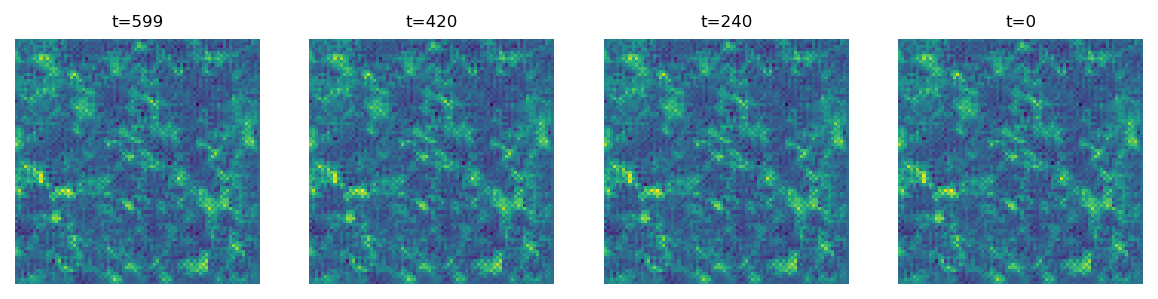

[ep 01] latent-L1 = 1.7436
✓ Сэмплы сохранены в ./samples

Epoch 2/30


epoch 01:   0%|                                                                                               …

C:\Users\User\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Loss = 0.5341189010620118


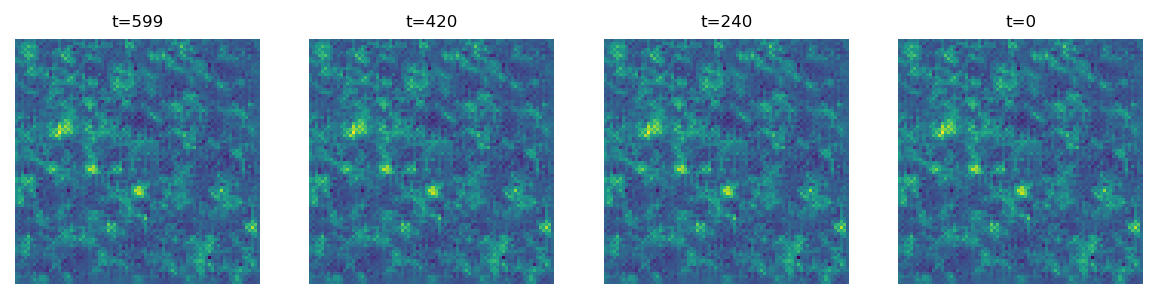

[ep 02] latent-L1 = 1.7430
✓ Сэмплы сохранены в ./samples

Epoch 3/30


epoch 02:   0%|                                                                                               …

In [ ]:
import re

SR      = 16_000                       # sample rate
N_MELS  = 80
N_FFT   = 1024
HOP     = 256
WIN     = 1024

def mel_to_audio(mel_log):
    """
    mel_log: (1,1,80,T)   лог-Mel-спектр → wav-тензор (T,)
    """
    mel = mel_log.exp().sub_(1e-6).squeeze(0).squeeze(0)   # [80,T]

    n_stft = N_FFT // 2 + 1
    spec = torchaudio.transforms.InverseMelScale(
        n_stft=n_stft, n_mels=N_MELS, sample_rate=SR)(mel)

    # подстраховка по частоте
    if spec.shape[0] < n_stft:
        spec = F.pad(spec, (0, 0, 0, n_stft - spec.shape[0]))
    elif spec.shape[0] > n_stft:
        spec = spec[:n_stft]

    griffin = torchaudio.transforms.GriffinLim(
        n_fft=N_FFT, hop_length=HOP, win_length=WIN,
        power=1.0, n_iter=64, momentum=0.99
    )
    wav = griffin(spec)          # (T,)
    return wav.clamp_(-1, 1)

@torch.no_grad()
def text_to_speech(text,
                   tts,
                   vae,
                   sched,
                   temp=0.7,
                   device=None):
    """
    text  – строка
    tts   – обученная диффузионная сеть
    vae   – VAE-декодер
    sched – NoiseScheduler из тренера
    temp  – «температура» начального шума (0-1)
    """

    # куда класть тензоры
    if device is None:
        device = next(tts.parameters()).device

    # текст в индексы
    ids = tts.word_enc.tokenize([text]).to(device)

    # узнаём форму латента для инициализации шума
    dummy_mel = torch.zeros(1, 1, 80, 80, device=device)
    zshape = tts.resize_to_square(
        vae.sample(dummy_mel)[0], tts.patch_img1_size
    ).shape

    z = torch.randn(zshape, device=device) * temp   # x_T

    # обратный процесс
    for t in reversed(range(sched.steps)):
        eps = tts(z, ids, torch.tensor([t], device=device))

        # выравниваем геометрию, если отличается
        if eps.shape[-2:] != z.shape[-2:]:
            eps = torch.nn.functional.interpolate(
                eps, z.shape[-2:], mode="bilinear", align_corners=False
            )

        sigma = 0.0 if t < sched.steps * 0.2 else 1e-4
        z = sched.restore_image(z, eps, t, sigma=sigma)

    mel = vae.decode(z).cpu()           # (1,1,80,T)
    wav = mel_to_audio(mel)             # (T,)
    return wav   

DEVICE = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
def slugify(text:str, maxlen:int=16)->str:
    text = re.sub(r"\s+", "_", text.lower())
    text = re.sub(r"[^\w\d_]+", "", text)
    return text[:maxlen]
CKPT_VAE = "VaeAudio_V4_noise.pt"
vae.load_state_dict(torch.load(CKPT_VAE, map_location=DEVICE, weights_only=True))

tts_model = TTS_diffusion(
    input_channels=32, hidden_dims=128,
    alphabet="абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
    emb_size_word=128, emb_size_noise=64,
    noise_steps=600, max_word_size=256, max_time_size=2048
).to(DEVICE)


# 5.4. Тренер
trainer = TTS_Trainer(tts_model, train_dataloader, val_dataloader, vae, epochs=30)

for epoch in range(trainer.epochs):
    print(f"\nEpoch {epoch+1}/{trainer.epochs}")
    trainer.train_loop(epoch=epoch)
    trainer.val_loop(iteration=epoch)

    trainer.model.eval()
    l1 = trainer.latent_l1_val(max_batches=20)
    print(f"[ep {epoch+1:02d}] latent-L1 = {l1:.4f}")

    for phrase in ["Привет, как дела?", "Сегодня солнечная погода."]:
        wav = text_to_speech(phrase, trainer.model, trainer.vae,
                             trainer.noise_sched, temp=0.7)
        fn = f"./samples/ep{epoch+1:02d}_{slugify(phrase)}.wav"
        torchaudio.save(fn, wav.unsqueeze(0), 16_000)

    print("✓ Сэмплы сохранены в ./samples")

torch.save(trainer.model.state_dict(), "TTSModelParametersNew_v6.pt")


 Epoch: 1/30


train:   0%|          | 0/157 [00:00<?, ?it/s]

Loss = 0.46089423780441285


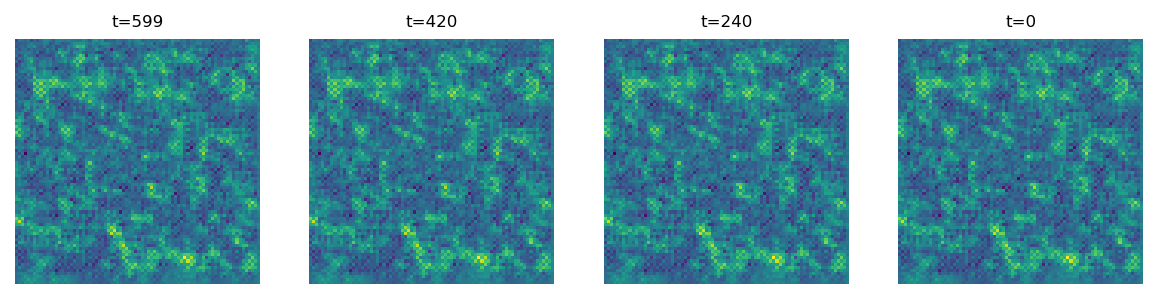

[epoch 01] validation latent-L1 = 0.5240


NameError: name 'tts' is not defined

In [15]:
# @torch.inference_mode()
# def text_to_speech(
#         text:str,S
#         tts:TTS_diffusion,
#         vae:VAE_Audio,
#         sched:NoiseScheduler,
#         temp:float = 0.7,
#         device:torch.device|str = None
#     )->torch.Tensor:

#     device = device or next(tts.parameters()).device
#     ids = tts.word_enc.tokenize([text]).to(device)

#     dummy  = torch.zeros(1, 1, 80, 80, device=device)
#     zshape = tts.resize_to_square(vae.sample(dummy)[0], tts.patch_img1_size).shape
#     z = torch.randn(zshape, device=device) * temp

#     for t in reversed(range(sched.steps)):
#         eps = tts(z, ids, torch.tensor([t], device=device))
#         if eps.shape[-2:] != z.shape[-2:]:
#             eps = torch.nn.functional.interpolate(eps, z.shape[-2:], mode="bilinear", align_corners=False)

#         sigma = 0.0 if t < sched.steps*0.2 else 1e-4
#         z = sched.restore_image(z, eps, t, sigma=sigma)

#     mel = vae.decode(z).cpu()
#     return mel_to_audio(mel)

# all_epochs = 30

# trainer = TTS_Trainer(
#     model=tts_model,
#     train_dataloader=train_dataloader,
#     val_dataloader=val_dataloader,
#     vae=vae,
#     epochs=all_epochs
# )

# for epoch in range(all_epochs):
#     print(f"\n Epoch: {epoch + 1}/{all_epochs}")
#     trainer.train_loop()
#     trainer.val_loop(iteration=epoch)
#     tts_model.eval()
#     l1_score = trainer.latent_l1_val(max_batches=20)
#     print(f"[epoch {epoch+1:02d}] validation latent-L1 = {l1_score:.4f}")
#     for text in ["Привет, как дела?",
#                  "Сегодня солнечная погода."]:
#         with torch.no_grad():
#             wav = text_to_speech(text, temp=0.7)
#         fn = f"./samples/ep{epoch+1:02d}_{text[:8]}.wav"
#         torchaudio.save(fn, wav.unsqueeze(0), 16_000)
#     print(f"Сэмплы сохранены в ./samples/ (эпоха {epoch+1})")

# torch.save(tts_model.state_dict(), "TTSModelParametersNew_v6.pt")

In [127]:
# ─── 1. Импорты ────────────────────────────────────────────────────────────
import torch, torchaudio, torch.nn.functional as F
from pathlib import Path
import IPython.display as ipd

# ─── 2. Глобальные параметры ───────────────────────────────────────────────
DEVICE, SR = ("cuda" if torch.cuda.is_available() else "cpu"), 16_000

# чуть шире FFT-окно и hop — лучше качество при Griffin-Lim
N_MELS, N_FFT, HOP, WIN = 80, 1024, 256, 1024

CKPT_VAE = Path("VaeAudio_V4_noise.pt")      # веса VAE
CKPT_TTS = Path("TTSModelParametersNew_v5.pt")  # веса диффузии

# ─── 3. Mel → Wave только Griffin-Lim ──────────────────────────────────────
def mel_to_audio(mel_log: torch.Tensor) -> torch.Tensor:
    """
    (1,1,80,T) лог-Mel  → wav (T,)
    Работает на любой версии torchaudio.
    """
    mel = mel_log.exp().sub_(1e-6).squeeze(0).squeeze(0)    # [80, T]

    # Inverse Mel → линейный спектр
    n_stft = N_FFT // 2 + 1
    spec   = torchaudio.transforms.InverseMelScale(
        n_stft=n_stft, n_mels=N_MELS, sample_rate=SR)(mel)

    # на всякий случай ровняем размер по частотам
    if spec.shape[0] < n_stft:
        spec = F.pad(spec, (0, 0, 0, n_stft - spec.shape[0]))
    elif spec.shape[0] > n_stft:
        spec = spec[:n_stft]

    # Griffin-Lim
    griffin = torchaudio.transforms.GriffinLim(
        n_fft=N_FFT, hop_length=HOP, win_length=WIN,
        power=1.0, n_iter=64, momentum=0.99
    )
    wav = griffin(spec)                    # (T,)
    return wav.clamp(-1, 1)

# ─── 4. Грузим обученные модели ────────────────────────────────────────────
vae = VAE_Audio().to(DEVICE)
vae.load_state_dict(torch.load(CKPT_VAE, map_location=DEVICE, weights_only=True))
vae.eval()

tts = TTS_diffusion(
    input_channels=32, hidden_dims=128,
    alphabet="абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
    emb_size_word=128, emb_size_noise=64,
    noise_steps=600, max_word_size=256, max_time_size=2048
).to(DEVICE)
tts.load_state_dict(torch.load(CKPT_TTS, map_location=DEVICE, weights_only=True))
tts.eval()

sched = NoiseScheduler(600)
sched.alpha      = sched.alpha.to(DEVICE)
sched.alpha_hat  = sched.alpha_hat.to(DEVICE)


# ─── 6. Проверка ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    phrase = "привет"
    audio  = text_to_speech(phrase)

    torchaudio.save("out.wav", audio.unsqueeze(0), SR)
    ipd.display(ipd.Audio(audio.numpy(), rate=SR))
    print("✓  Готово: out.wav сохранён.")


✓  Готово: out.wav сохранён.


In [5]:
from pathlib import Path
xx = Path("dataset.tsv")
import pandas as pd
df = pd.read_csv(xx, sep="\t")

C:\Users\User\AppData\Local\Temp\ipykernel_11196\816554738.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(xx, sep="\t")


In [10]:
df['path'] = df['path'].str.replace(r'\.mp3$', '.wav', regex=True)

In [129]:
df

NameError: name 'df' is not defined

In [28]:
import pandas as pd
from pathlib import Path

SRC_TSV   = Path(r"E:\data\dataset.tsv")   # ваш исходный tsv
TRAIN_CSV = Path(r"E:\data\train.csv")     # куда сохранить train
VAL_CSV   = Path(r"E:\data\val.csv")       # куда сохранить val
SEED = 42                             # чтобы деление было воспроизводимым
VAL_FRAC = 0.10                           # 10 % на валидацию

# ─── 1. читаем TSV ───────────────────────────────────────────────
df = pd.read_csv(SRC_TSV, sep='\t')

# ─── 2. случайно перемешиваем и делим ────────────────────────────
val_df   = df.sample(frac=VAL_FRAC, random_state=SEED)
train_df = df.drop(val_df.index)

# ─── 3. сохраняем в CSV (без индексов) ───────────────────────────
train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VAL_CSV,     index=False)

print(f"✓ train: {len(train_df):,}  |  val: {len(val_df):,}")


C:\Users\User\AppData\Local\Temp\ipykernel_11196\586357610.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SRC_TSV, sep='\t')


✓ train: 153,004  |  val: 17,000


In [32]:
# быстро отсекаем всё тише -35 dBFS
import soundfile as sf, numpy as np, glob
bad = []
for f in glob.glob("bare_data/*.wav"):
    rms = np.sqrt(np.mean(sf.read(f)[0]**2))
    if 20*np.log10(rms+1e-9) < -35: bad.append(f)
print("тихих файлов:", len(bad))


тихих файлов: 0


In [5]:
pip install hifi-gan==0.1.1


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement hifi-gan==0.1.1 (from versions: 0.0.1, 0.0.2)
ERROR: No matching distribution found for hifi-gan==0.1.1


In [131]:
# --- один батч, один шаг ---
mel, txt = next(iter(train_dataloader))          # (B,1,80,80)
mel = mel.to(device)

with torch.no_grad():
    z, _, _ = vae.sample(mel)                    # (B,32,*,*)  ← НЕ ресайзим!

idx  = sched.get_idx(0, z.size(0)).to(device)
txts = tts_model.word_enc.tokenize(txt).to(device)

out = tts_model(z, txts, idx)                    # (B,32,H',W')

# приводим к одной геометрии, если нужно
if out.shape[-2:] != z.shape[-2:]:
    z = torch.nn.functional.interpolate(
            z, size=out.shape[-2:], mode='bilinear', align_corners=False)

print('latent l1 =', (out - z).abs().mean().item())


latent l1 = 1.9066026210784912
